# Multilayer Perceptron (MLP) for Wildfire Detection

This notebook implements and tunes a Multilayer Perceptron neural network for wildfire detection using NASA satellite measurement data.


In [1]:
# Standard library imports
import os

# Third-party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn imports
from sklearn.model_selection import train_test_split

# Configuration
DATA_PATH = "../data/final_combined_dataset.csv"
RANDOM_STATE = 1234
TEST_SIZE = 0.2

# Load dataset
data = pd.read_csv(DATA_PATH)

# Prepare features and target
X = data.drop(["FIRE", "Date"], axis=1)
y = data['FIRE']

# Split data into training and testing sets
X_train, X_test, y_train, y_test, data_train, data_test = train_test_split(
    X, y, data, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Display dataset shapes
print("Dataset splits:")
print(f"  Training set: {X_train.shape}")
print(f"  Test set:     {X_test.shape}")
print(f"\nLabel shapes:")
print(f"  Training labels: {y_train.shape}")
print(f"  Test labels:     {y_test.shape}")

# Assign y to the 'FIRE' column in data
y = data['FIRE']

# Set seed for reproducabilty
X_train, X_test, y_train, y_test, data_train, data_test = train_test_split(X, y, data, test_size = 0.2, random_state = 1234)



print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


/home/paul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Dataset splits:
  Training set: (23960, 12)
  Test set:     (5990, 12)

Label shapes:
  Training labels: (23960,)
  Test labels:     (5990,)
(23960, 12)
(5990, 12)
(23960,)
(5990,)


In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score,
                            recall_score, f1_score, roc_auc_score, roc_curve, classification_report,
                            confusion_matrix, ConfusionMatrixDisplay)


# Evaluates pipelines passed
def evaluate_pipelines(pipelines, X_train, y_train, X_evaluate, y_evaluate):
    rows = []
    for name, pipeline in pipelines:
        pipeline.fit(X_train, y_train)

        train_preds = pipeline.predict(X_train)
        test_preds = pipeline.predict(X_test)

        training_accuracy = accuracy_score(y_train, train_preds)
        testing_accuracy = accuracy_score(y_test, test_preds)

        training_recall = recall_score(y_train, train_preds)
        testing_recall = recall_score(y_test, test_preds)

        training_precision = precision_score(y_train, train_preds)
        testing_precision = precision_score(y_test, test_preds)

        training_f1 = f1_score(y_train, train_preds)
        testing_f1 = f1_score(y_test, test_preds)

        rows.append({'name': name, 'Training Accuracy': training_accuracy, 'Eval Accuracy': testing_accuracy,
                     'Training Recall': training_recall, 'Eval Recall': testing_recall,
                     'Training Precision': training_precision, 'Eval Precision': testing_precision,
                     'Training F1': training_f1, 'Eval F1': testing_f1})

    display(pd.DataFrame(rows))

# Plots confusion matrix
def plot_confusion_matrix(y_true, y_pred, clf_name):
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure
    plt.figure()

    # Use seaborn to plot confusion matrix
    sns.heatmap(cm, annot = True, fmt = 'g', cmap='viridis')

    # Labels/title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{clf_name} Confusion Matrix')

    # Display plot
    plt.show()


def plot_roc_curve(y_test, y_probs):

  #calculate auc
  auc = roc_auc_score(y_test, y_probs)

  #plot
  fpr, tpr, _ = roc_curve(y_test, y_probs)
  plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend()
  plt.show()


mlp_base = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('mlp',    MLPClassifier(
                  max_iter   = 500,
                  random_state = 1234,
                  early_stopping = True,
                  n_iter_no_change = 20,
              ))
])

In [3]:

param_grid = {
    'mlp__hidden_layer_sizes': [(32,), (64,), (32, 16), (64, 32)],
    'mlp__activation'        : ['relu', 'tanh'],
    'mlp__alpha'             : [1e-5, 1e-4, 1e-3],
    'mlp__learning_rate_init': [1e-3, 1e-2],
}

mlp_search = GridSearchCV(
    estimator  = mlp_base,
    param_grid = param_grid,
    scoring    = 'roc_auc',
    cv         = 5,
    n_jobs     = -1,
    verbose    = 2,
)

# 4.  Fit the search on the training data
mlp_search.fit(X_train, y_train)

print("Best params:",  mlp_search.best_params_)
print("Best ROC‑AUC:", mlp_search.best_score_)

# 5.  Stick the tuned model into your existing evaluation helpers
best_mlp = mlp_search.best_estimator_



Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END mlp__activation=relu, mlp__alpha=1e-05, mlp__hidden_layer_sizes=(32,), mlp__learning_rate_init=0.01; total time=   2.4s
[CV] END mlp__activation=relu, mlp__alpha=1e-05, mlp__hidden_layer_sizes=(32,), mlp__learning_rate_init=0.01; total time=   2.8s
[CV] END mlp__activation=relu, mlp__alpha=1e-05, mlp__hidden_layer_sizes=(32,), mlp__learning_rate_init=0.01; total time=   3.2s
[CV] END mlp__activation=relu, mlp__alpha=1e-05, mlp__hidden_layer_sizes=(32,), mlp__learning_rate_init=0.01; total time=   3.6s
[CV] END mlp__activation=relu, mlp__alpha=1e-05, mlp__hidden_layer_sizes=(32,), mlp__learning_rate_init=0.01; total time=   4.3s
[CV] END mlp__activation=relu, mlp__alpha=1e-05, mlp__hidden_layer_sizes=(64,), mlp__learning_rate_init=0.001; total time=   4.0s
[CV] END mlp__activation=relu, mlp__alpha=1e-05, mlp__hidden_layer_sizes=(32,), mlp__learning_rate_init=0.001; total time=   5.7s
[CV] END mlp__activation=relu, ml

,name,Training Accuracy,Eval Accuracy,Training Recall,Eval Recall,Training Precision,Eval Precision,Training F1,Eval F1
0,Base MLP,0.970618,0.964942,0.982937,0.977180,0.959457,0.952523,0.971055,0.964694
1,Tuned MLP,0.974624,0.967279,0.983020,0.974796,0.966923,0.959115,0.974905,0.966892



Training Base MLP...


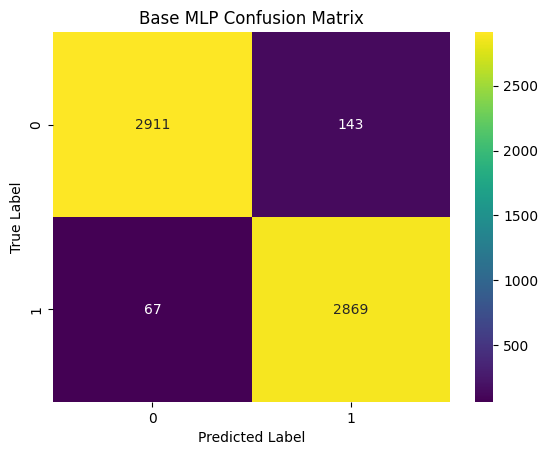

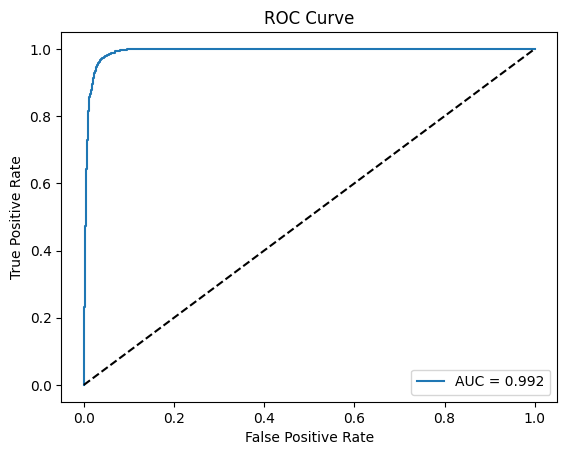


Training Tuned MLP...


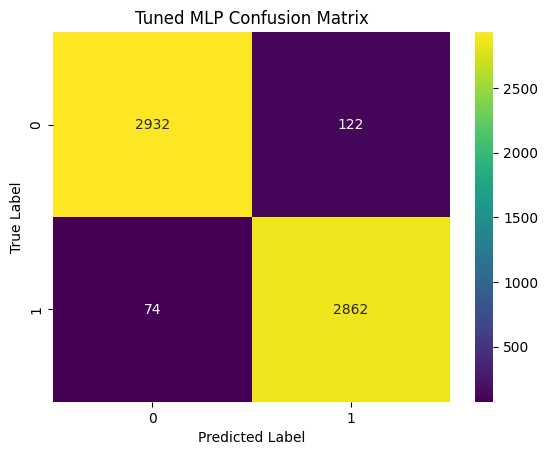

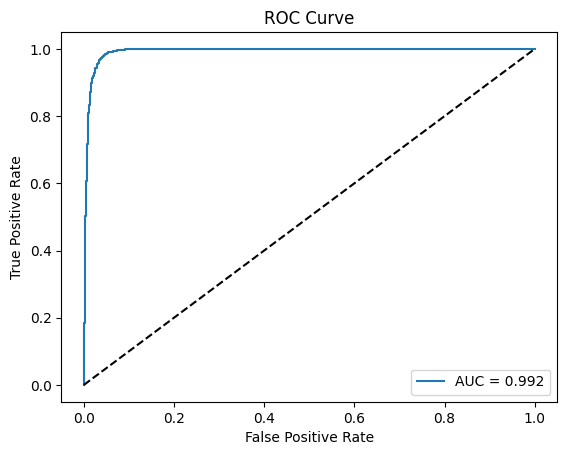

In [4]:
tuned_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp',    MLPClassifier(
                   max_iter         = 500,
                   random_state     = 1234,
                   early_stopping   = True,
                   n_iter_no_change = 20,
                   hidden_layer_sizes = (64, 32 ),
                   activation         = 'relu',
                   alpha              = 0.0001,
                   learning_rate_init = 0.01,
               ))
])

evaluate_pipelines([
    ('Base MLP',  mlp_base),
    ('Tuned MLP', tuned_mlp),
], X_train, y_train, X_test, y_test)

# 4) Confusion + ROC as before
clfs = [
    ('Base MLP',  mlp_base),
    ('Tuned MLP', tuned_mlp),
]

for name, clf in clfs:
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    y_pred  = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)[:, 1]
    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(y_test, y_probs)

               Feature  Importance
1            Longitude    0.168078
8                   PS    0.101898
0             Latitude    0.053335
7                 RH2M    0.004622
2                 WS2M    0.004128
5              T2M_MIN    0.004093
4              T2M_MAX    0.001735
6               T2MDEW    0.001377
3                  T2M    0.001188
9    ALLSKY_SFC_LW_DWN    0.000872
11  ALLSKY_SFC_SW_DIFF    0.000502
10   ALLSKY_SFC_SW_DWN    0.000105


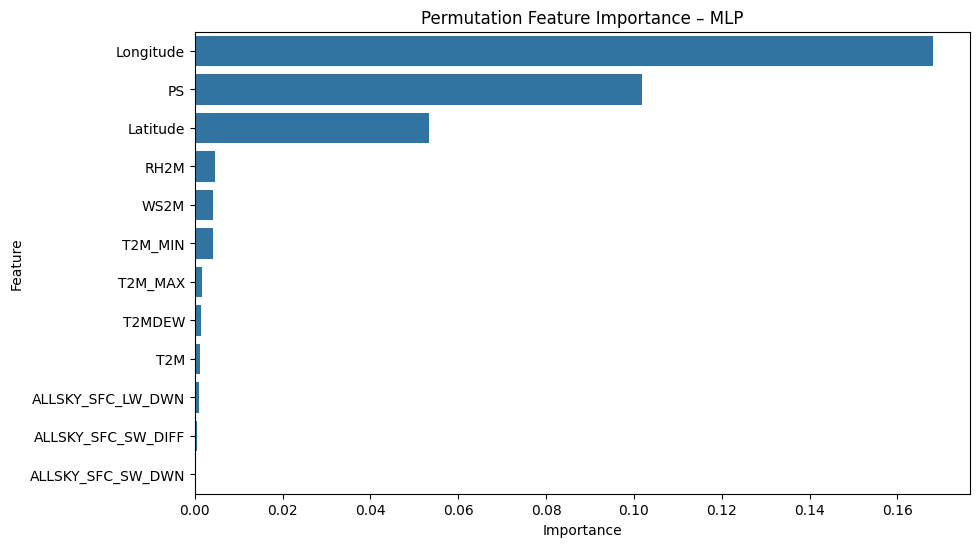

In [5]:
perm = permutation_importance(
    estimator = tuned_mlp,
    X         = X_test,
    y         = y_test,
    n_repeats = 15,
    scoring   = 'roc_auc',
    random_state = 1234,
    n_jobs    = -1,
)

# Put into a tidy DataFrame
perm_df = (pd.DataFrame({'Feature': X_test.columns,
                         'Importance': perm.importances_mean})
             .sort_values('Importance', ascending=False))

print(perm_df)

plt.figure(figsize=(10,6))
sns.barplot(y='Feature', x='Importance', data=perm_df)
plt.title("Permutation Feature Importance – MLP")
plt.show()